In [1]:
from math import sqrt
from scipy.fft import fft
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

import numpy as np
from scipy.ndimage import maximum_filter

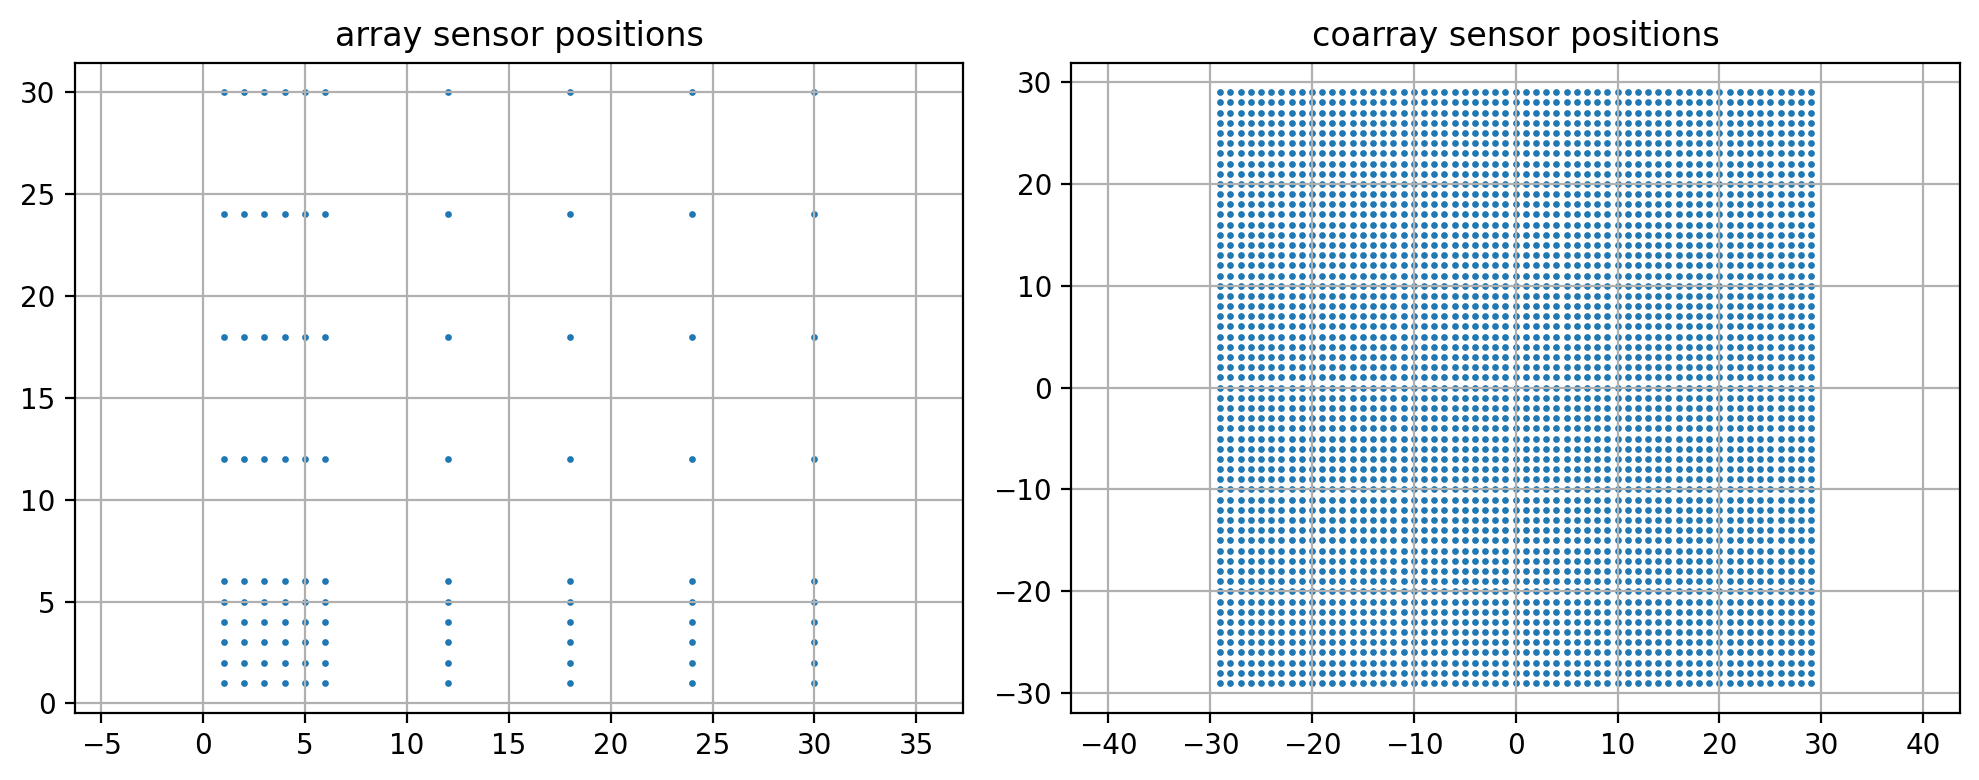

In [2]:
levels_horizontal = [5, 5]
levels_vertical = [5, 5]

# levels_horizontal = [10, 10]
# levels_vertical = [10, 10]

nbSensors = sum(levels_horizontal) * sum(levels_vertical)

mult = 1
pos_horizontal = []
for i in range(len(levels_horizontal)):
    pos_horizontal += [(k + 1) * mult for k in range(levels_horizontal[i])]
    mult *= levels_horizontal[i] + 1

mult = 1
pos_vertical = []
for i in range(len(levels_vertical)):
    pos_vertical += [(k + 1) * mult for k in range(levels_vertical[i])]
    mult *= levels_vertical[i] + 1

x = np.tile(np.array(pos_horizontal), sum(levels_vertical)).tolist()
y = np.repeat(np.array(pos_vertical), sum(levels_horizontal)).tolist()

pos_coarray_set = set()
for i in range(nbSensors):
    for j in range(nbSensors):
        pos_coarray_set.add((x[i] - x[j], y[i] - y[j]))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(x, y, s=2)
axes[0].set_title('array sensor positions')
axes[0].axis('equal')
axes[0].grid(True)

# Second subplot
axes[1].scatter(np.array(list(pos_coarray_set))[:, 0], np.array(list(pos_coarray_set))[:, 1], s=2)
axes[1].set_title('coarray sensor positions')
axes[1].axis('equal')
axes[1].grid(True)

# Improve layout
plt.tight_layout()
plt.show()

In [3]:
t = 200
nbSources = 5
snr = -10

theta = np.random.rand(nbSources) * np.pi / 2
phi = np.random.rand(nbSources) * np.pi 
d_lamda_ratio = 1 / 2

A = np.exp(1j * 2 * np.pi * d_lamda_ratio * (np.array(x).reshape(-1, 1) * (np.sin(theta) * np.cos(phi)).reshape(1, -1) \
                                           + np.array(y).reshape(-1, 1) * (np.sin(theta) * np.sin(phi)).reshape(1, -1)))
S = (np.random.randn(nbSources, t) + 1j * np.random.randn(nbSources, t)) / sqrt(2)
N = (np.random.randn(nbSensors, t) + 1j * np.random.randn(nbSensors, t)) / sqrt(2) * sqrt(nbSources) * 10 ** (-snr/20)

X = A @ S + N

In [4]:
pos_coarray_dict = {}
for pos in pos_coarray_set: pos_coarray_dict[pos] = []

for i in range(nbSensors):
    for j in range(nbSensors):
        pos = (x[i] - x[j], y[i] - y[j])
        pos_coarray_dict[pos].append((i, j))

R = X @ X.T.conj() / t
coarray_covariance = {}

for pos, indices in pos_coarray_dict.items():
    indices = np.array(indices)
    values = np.mean(R[indices[:, 0], indices[:, 1]])
    coarray_covariance[pos] = values

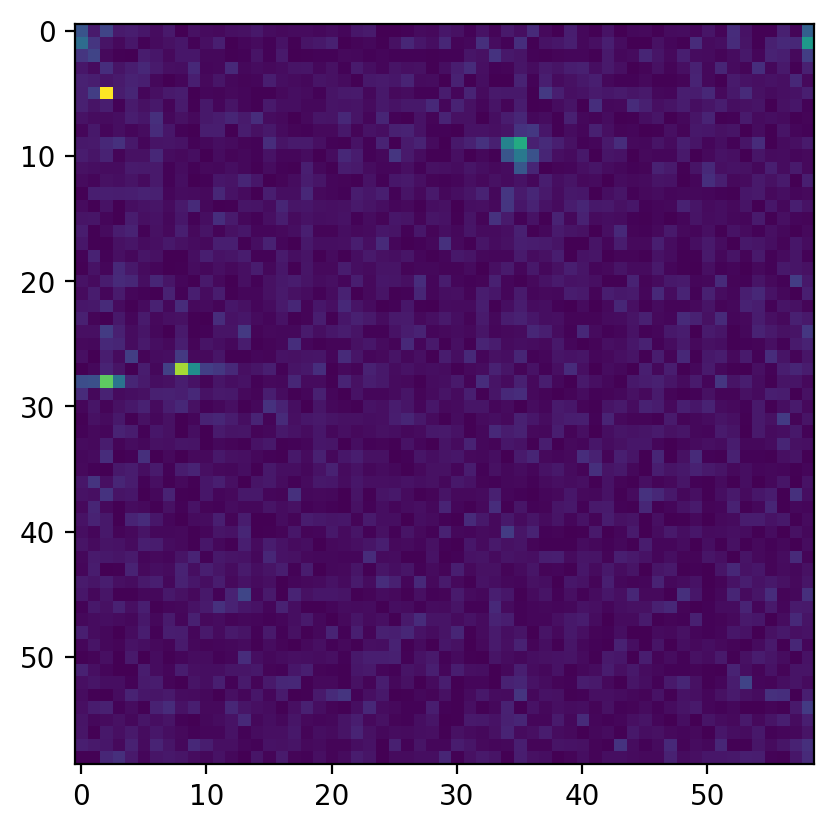

In [5]:
size_x_coarray = pos_horizontal[-1] - pos_horizontal[0]
size_y_coarray = pos_vertical[-1] - pos_vertical[0]

R_coarray = []
for j in range(- size_y_coarray, size_y_coarray + 1):
    for i in range(- size_x_coarray, size_x_coarray + 1):
        R_coarray.append(coarray_covariance[(i, j)])
R_coarray = np.array(R_coarray).reshape(2 * size_y_coarray + 1, 2 * size_x_coarray + 1)

fft_R_coarray = np.abs(fft(fft(R_coarray, axis=0), axis=1))
plt.imshow(fft_R_coarray);

In [6]:
def refine_curve_fitting(y):
    A = np.array([[1, 1, 1, -1, -1, 1],
                  [0, 1, 0, 0, -1, 1],
                  [1, 1, -1, 1, -1, 1],
                  [1, 0, -1, 0, 0, 1],
                  [0, 0, 0, 0, 0, 1],
                  [1, 0, 1, 0, 0, 1],
                  [1, 1, -1, -1, 1, 1],
                  [0, 1, 0, 0, 1, 1],
                  [1, 1, 1, 1, 1, 1]])
    coefs = np.linalg.lstsq(A, y)[0]
    a, b, c, d, e = coefs[0], coefs[1], coefs[2], coefs[3], coefs[4]
    if (4 * a * b < c * c) or (4 * a * b >= c * c and a > 0): 
        sol = np.array([0, 0])
    else:
        sol = np.linalg.solve(np.array([[2 * a, c],
                                        [c, 2 * b]]), np.array([-d, -e]))
    return sol


def arctan2_custom(y, x):
    angle = np.arctan2(y, x)
    angle = np.where(angle < 0, angle + np.pi * 2, angle)
    angle = np.where(angle > np.pi, 2 * np.pi - angle, angle)
    return angle  

matrix = np.array(fft_R_coarray)
neighborhood = maximum_filter(matrix, size=3, mode='constant', cval=-np.inf)
peaks_mask = (matrix == neighborhood)

for shift in [(-1,0), (1,0), (0,-1), (0,1)]:
    shifted = np.roll(matrix, shift, axis=(0,1))
    mask = np.ones_like(matrix, dtype=bool)
    if shift[0] == -1:
        mask[0,:] = False
    elif shift[0] == 1:
        mask[-1,:] = False
    if shift[1] == -1:
        mask[:,0] = False
    elif shift[1] == 1:
        mask[:,-1] = False
    peaks_mask &= (matrix > shifted) | ~mask  

peak_indices = np.argwhere(peaks_mask)
peak_values = matrix[peaks_mask]
sorted_indices = np.argsort(-peak_values)
top_peaks = [(peak_indices[i]) for i in sorted_indices[:nbSources]]

top_peaks_refined = []

for j, i in top_peaks:
    if 1 <= j <= 2*size_y_coarray and 1 <= i <= 2*size_x_coarray:
        nine_points = np.array([fft_R_coarray[j-1, i-1], fft_R_coarray[j, i-1], fft_R_coarray[j+1, i-1],
                                fft_R_coarray[j-1, i], fft_R_coarray[j, i], fft_R_coarray[j+1, i],
                                fft_R_coarray[j-1, i+1], fft_R_coarray[j, i+1], fft_R_coarray[j+1, i+1]])
        del_ji = refine_curve_fitting(nine_points)
        print(del_ji)
        top_peaks_refined.append((j+del_ji[0], i+del_ji[1]))
    else:
        top_peaks_refined.append((j, i))

results = []

for j, i in top_peaks_refined:
    if i <= (2 * size_x_coarray + 1) * d_lamda_ratio: b1 = - i / (d_lamda_ratio * (2 * size_x_coarray + 1))
    else: b1 = (1 - i / (2 * size_x_coarray + 1)) / d_lamda_ratio
    if j <= (2 * size_y_coarray + 1) * d_lamda_ratio: b2 = - j / (d_lamda_ratio * (2 * size_y_coarray + 1))
    else: b2 = (1 - j / (2 * size_y_coarray + 1)) / d_lamda_ratio
    results.append([np.arcsin(np.sqrt(b1 ** 2 + b2 ** 2)), arctan2_custom(- b2, - b1)])

results = np.array(results)

[-0.0324881  -0.04406155]
[0.00767497 0.10476983]
[-0.00768204  0.07638053]
[ 0.21157375 -0.11026805]


IndexError: index 59 is out of bounds for axis 1 with size 59

In [ ]:
plt.scatter(results[:, 0], results[:, 1], marker='o', color='red', s=10, label='FFT peak')  # Circle marker
plt.scatter(theta, phi, marker='+', color='green', s=10, label='Target')  # X marker

plt.xlim(0, np.pi / 2) 
plt.ylim(0, np.pi)  

plt.xlabel(r'$\theta$ (rad)')
plt.ylabel(r'$\phi$ (rad)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()